In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [28]:
def make_test(optimizer_class, title, params, n_epochs=200, use_closure=False):
    # модель
    model = MLP(20, 10)

    # Критерий/ функция потерь
    criterion = torch.nn.BCELoss()

     # Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS
    optimizer = optimizer_class(model.parameters(), **params)
    
    sns.set()
    # колво эпох. Меняйте

    # размер батча. Тоже меняйте если хотите
    batch_size = 8 

    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []
        
        # https://stackoverflow.com/questions/57806980/how-can-i-use-the-lbfgs-optimizer-with-pytorch-ignite
        # https://github.com/pytorch/pytorch/issues/49993
        def closure():
            nonlocal loss_array
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
            outputs = model.forward(x=batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_array.append(loss.item())
            loss.backward()
            return loss

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
            #  your code here 
            if use_closure:
                optimizer.step(closure)
            else:
                optimizer.zero_grad()  # sets the gradients of all optimized torch.Tensor s to zero

                # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x_train[indices], y_train[indices]

                # Считаем лосс и добавляем его значение в массив
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)

                loss_array.append(loss.item())
                loss.backward()
                
                optimizer.step()


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

    #display.clear_output(wait=True)
    #plt.figure(figsize =(12, 7))
    plt.title(title, fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.plot(epoch_array, label ="TRAIN")
    plt.plot(epoch_test_array, label ="TEST")
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('Номер итерации', fontsize=18)
    plt.legend(loc="best", fontsize=20)
    #plt.show()

In [29]:
tests = [
    {'optimizer_class': torch.optim.Adam, 'title': 'Adam' ,'params': {'lr': 2e-4}, 'n_epochs': 300, 'use_closure': False},
    {'optimizer_class': torch.optim.RMSprop, 'title': 'RMSprop' ,'params': {'lr': 2e-4},
     'n_epochs': 300, 'use_closure': False},
    {'optimizer_class': torch.optim.SGD, 'title': 'SGD' ,'params': {'lr': 2e-2}, 'n_epochs': 300, 'use_closure': False},
    {'optimizer_class': torch.optim.LBFGS, 'title': 'L-BFGS' ,'params': {'lr': 2e-4},
     'n_epochs': 300, 'use_closure': True},
]

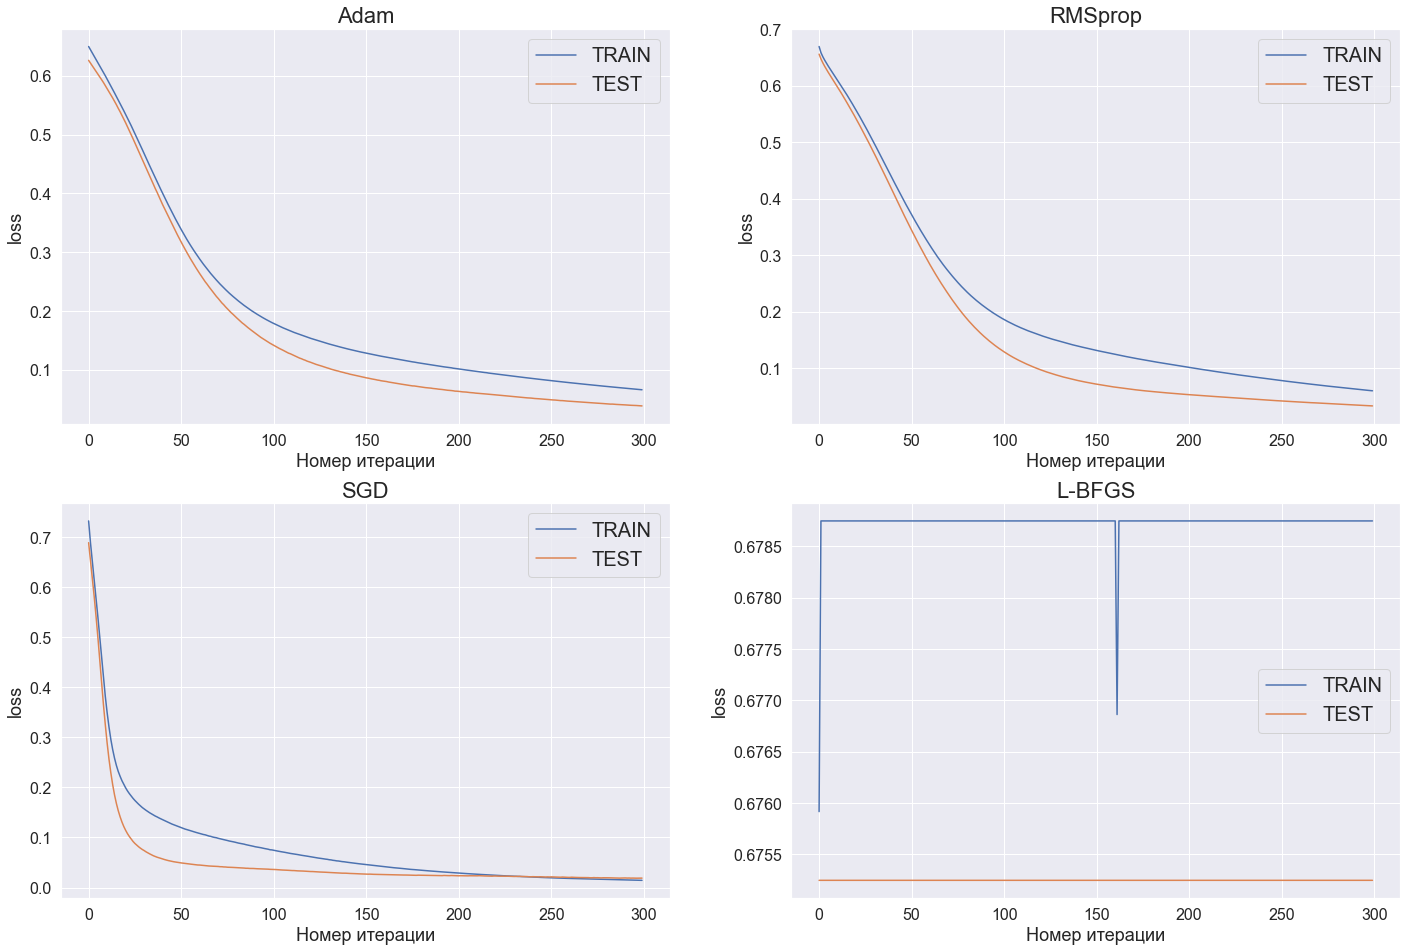

In [30]:
plt.figure(figsize=(24, 16))

for i, test in enumerate(tests):
    plt.subplot(2, 2, i + 1)
    make_test(test['optimizer_class'], test['title'], test['params'], test['n_epochs'], test['use_closure'])
    
plt.show()

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

**Вывод:**

- рассмотрели работу различных оптимизаторов (по 300 итераций работы каждого)
- Adam,RMSPROP, SGD cходятся, вид графиков и скорость сходимости похожи (для честного сравнения нужно правильно learning rate выставлять) 
- с L-BFGS творится что-то неведомое, он не сходится и loss неприлично большой
- на сходящихся методах большого переобучения не происходит, сходимость как на TRAIN, так и на TEST